## Importing the basic libraries

In [1]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

## Importing the squad 2.0 dataset

In [2]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [3]:
%%capture
!pip install transformers

## Retrieving and storing the data

In [4]:
# Give the path for train data
path = Path('squad/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [5]:
# Give the path for validation data
path = Path('squad/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

## Checking the data

In [6]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [7]:
print("Passage: ",train_texts[0])  
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [8]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [9]:
print("Passage: ",val_texts[0])  
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


## Finding the end position character in train and validation data

In [10]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)
    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2  

In [11]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)
    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2   

## Tokenizing passages and queries

In [12]:
# here I used the 'bert-base-uncased' model for tokenization

In [13]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Convert the start-end positions to tokens start-end positions

In [14]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  count = 0
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
    # if start position is None, the answer passage is truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length
  print(count)
  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

10
16


## Creating a dataset class

In [15]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [16]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## Use of DataLoader

In [17]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                              else 'cpu')

## Building the Bert model

In [19]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 3
# epochs = 4

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

## Training and evaluating the model

In [20]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()
    
  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader): 
    
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass 
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ####Evaluation

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):
    
    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss 
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 10853 
Loss: 2.3 

Batch 2000 / 10853 
Loss: 1.2 

Batch 3000 / 10853 
Loss: 1.7 

Batch 4000 / 10853 
Loss: 1.3 

Batch 5000 / 10853 
Loss: 2.1 

Batch 6000 / 10853 
Loss: 1.6 

Batch 7000 / 10853 
Loss: 1.9 

Batch 8000 / 10853 
Loss: 0.8 

Batch 9000 / 10853 
Loss: 1.5 

Batch 10000 / 10853 
Loss: 1.4 

############Evaluate############
Batch 1000 / 2538 
Loss: 2.2 

Batch 2000 / 2538 
Loss: 0.7 


-------Epoch  1 -------
Training Loss: 1.3505454985672873 
Validation Loss: 1.1798296458872404 
Time:  5219.835291624069 
----------------------- 


############Train############
Batch 1000 / 10853 
Loss: 1.0 

Batch 2000 / 10853 
Loss: 0.6 

Batch 3000 / 10853 
Loss: 1.4 

Batch 4000 / 10853 
Loss: 0.4 

Batch 5000 / 10853 
Loss: 0.9 

Batch 6000 / 10853 
Loss: 1.6 

Batch 7000 / 10853 
Loss: 0.8 

Batch 8000 / 10853 
Loss: 0.6 

Batch 9000 / 10853 
Loss: 0.3 

Batch 10000 / 10853 
Loss: 1.0 

############Evaluate############
Batch 1000 / 2538 
L

In [23]:
# Save model
torch.save(model,"/content/finetunedmodel")

## Plotting train and validation losses

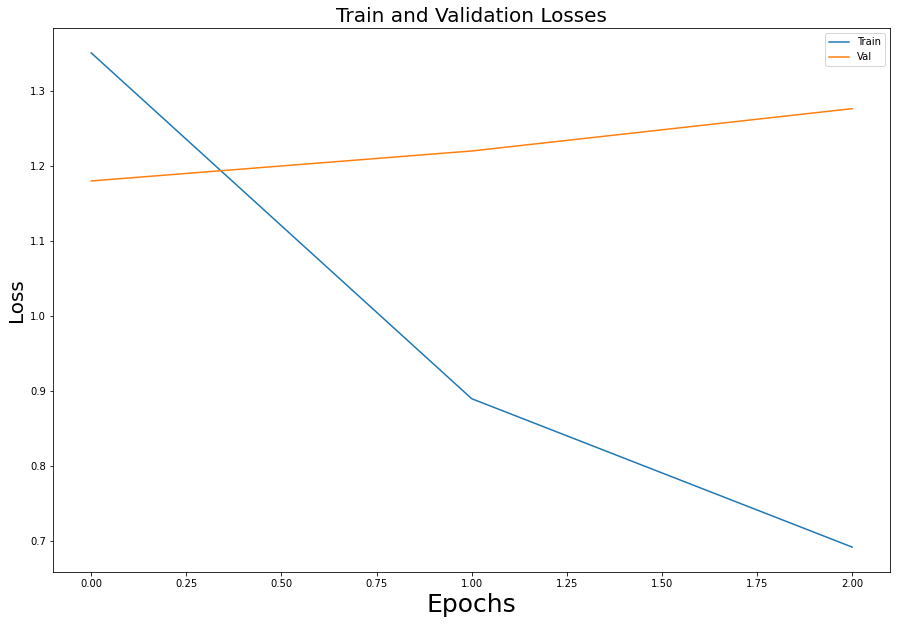

In [24]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

## Moving towards the evaluation

In [25]:
import torch
from transformers import AutoTokenizer,BertTokenizerFast

In [26]:
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the fine-tuned modeol
model = torch.load("/content/finetunedmodel",map_location=torch.device('cpu'))
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

## Making the prediction and evaluating it

In [27]:
def predict(context,query):

  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

def normalize_text(s):
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)

In [28]:
def give_an_answer(context,query,answer):

  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

## Testing the model with some examples

In [30]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How old is Alexa?
Prediction: 21
True Answer: 21
EM: 1
F1: 1.0


Question: Where does Alexa live now?
Prediction: kaisariani
True Answer: Kaisariani of Athens
EM: 0
F1: 0.5


Question: Where Alexa used to live?
Prediction: kaisariani
True Answer: Peristeri of Athens
EM: 0
F1: 0




In [31]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced 
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly 
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970.
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: freddie mercury
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.3636363636363636


Question: What kind of band they are?
Prediction: freddie mercury ( lead vocals, piano ), brian may ( guitar, vocals ), roger taylor ( drums, vocals ) and john deacon ( bass ). their earliest works were influenced by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio - friendly works by incorporating further styles, such as arena rock and pop rock.
True Answer: rock
EM: 0
F1: 0.03773584905660378




In [32]:
context = """ Mount Olympus is the highest mountain in Greece. It is part of the Olympus massif near 
              the Gulf of Thérmai of the Aegean Sea, located in the Olympus Range on the border between 
              Thessaly and Macedonia, between the regional units of Pieria and Larissa, about 80 km (50 mi) 
              southwest from Thessaloniki. Mount Olympus has 52 peaks and deep gorges. The highest peak, 
              Mytikas, meaning "nose", rises to 2917 metres (9,570 ft). It is one of the 
              highest peaks in Europe in terms of topographic prominence. """

queries = [
           "How many metres is Olympus?",
           "Where Olympus is near?",
           "How far away is Olympus from Thessaloniki?"
          ]
answers = [
           "2917",
           "Gulf of Thérmai of the Aegean Sea",
           "80 km (50 mi)"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How many metres is Olympus?
Prediction: 2917
True Answer: 2917
EM: 1
F1: 1.0


Question: Where Olympus is near?
Prediction: mytikas,
True Answer: Gulf of Thérmai of the Aegean Sea
EM: 0
F1: 0


Question: How far away is Olympus from Thessaloniki?
Prediction: 
True Answer: 80 km (50 mi)
EM: 0
F1: 0




In [33]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           ""
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: coronavirus disease 2019
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 0
F1: 0.6666666666666666


Question: What is caused by COVID-19?
Prediction: 
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0


Question: How many cases have been confirmed from COVID-19?
Prediction: 105 million
True Answer: more than 105 million cases
EM: 0
F1: 0.5714285714285715


Question: How many deaths have been confirmed from COVID-19?
Prediction: 2. 3 million
True Answer: more than 2.3 million deaths
EM: 0
F1: 0.25


Question: How is COVID-19 spread?
Prediction: the virus spreads mainly through the air when people are near each other.
True Answer: mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.
EM: 0
F1: 0.375


Question: How long can